In [1]:
import torch
from adaptive_control_gym.envs import DroneEnv
from adaptive_control_gym.envs.drone import ResDynMLP
from tqdm import trange

/home/pcy/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
env = DroneEnv(env_num = 128, gpu_id = 0, seed = 1, res_dyn_param_dim = 1)
agent = torch.load('/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_no_wind.pt', map_location=torch.device('cuda:0'))
policy = agent['actor']
for p in policy.parameters():
    p.requires_grad = False

In [15]:
res_dyn_fit = ResDynMLP(input_dim=env.dim+2+env.res_dyn_param_dim, output_dim=env.dim).to(env.device)
for p in res_dyn_fit.parameters():
    p.requires_grad = True
# optimizer
optimizer = torch.optim.Adam(res_dyn_fit.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss(reduction="mean")

In [16]:
# collect data with env and fit res_dyn_fit
repeat_times = 1
state, info = env.reset()
vs = torch.zeros((env.max_steps*repeat_times, env.env_num, 3), dtype=torch.float32).to('cuda:0')
us = torch.zeros((env.max_steps*repeat_times, env.env_num, 2), dtype=torch.float32).to('cuda:0')
ws = torch.zeros((env.max_steps*repeat_times, env.env_num, 1), dtype=torch.float32).to('cuda:0')
res_forces = torch.zeros((env.max_steps*repeat_times, env.env_num, 3), dtype=torch.float32).to('cuda:0')
for t in trange(env.max_steps*repeat_times):
    action = policy.get_action(state, info['e'])[0]
    vs[t] = env.v
    us[t] = action
    ws[t] = env.res_dyn_param
    state, reward, done, info = env.step(action)
    res_forces[t] = env.res_dyn_force
# train res_dyn_fit
data_in = torch.cat([vs, us, ws], dim=-1).reshape(env.max_steps*env.env_num*repeat_times, env.dim+2+env.res_dyn_param_dim)
data_out = res_forces.reshape(env.max_steps*env.env_num*repeat_times, 3)
batch_size = 1024
losses = []
for _ in trange(env.max_steps*repeat_times*env.env_num//batch_size*2):
    idx = torch.randint(0, env.max_steps*repeat_times*env.env_num, (batch_size,))
    d_in = data_in[idx]
    d_out = data_out[idx]
    d_pred = res_dyn_fit(d_in)
    loss = criterion(d_pred, d_out)*5.0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 30/30 [00:00<00:00, 1710.45it/s]


In [17]:
# agent = torch.load('/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_mlp_expert_Dw1.pt', map_location=torch.device('cuda:0'))
# policy = agent['actor']
# evulate with environment
state, info = env.reset()
total_loss = 0
for t in trange(env.max_steps*repeat_times):
    action = policy.get_action(state, info['e'])[0]
    res_force_pred = res_dyn_fit(torch.cat([env.v, action, env.res_dyn_param], dim=-1))
    state, reward, done, info = env.step(action)
    res_force_loss = torch.mean(torch.square(res_force_pred - env.res_dyn_force))
    total_loss += res_force_loss.item()
loss_mean = total_loss/(env.max_steps*repeat_times)
print(loss_mean)

100%|██████████| 120/120 [00:00<00:00, 913.08it/s]

0.03264659681978325


In [18]:
# save res_dyn_fit
torch.save(res_dyn_fit, f'/home/pcy/rl/policy-adaptation-survey/results/rl/res_dyn_fit_{env.env_num}_{loss_mean:.3f}.pt')

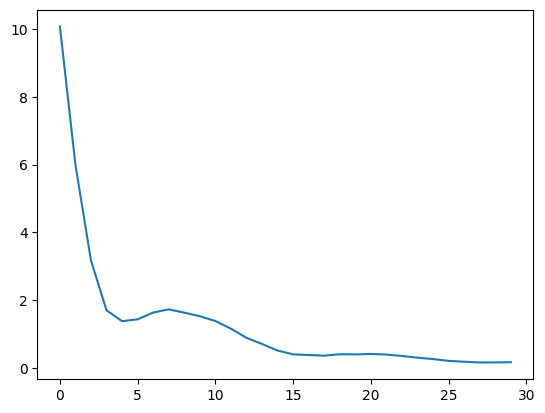

In [19]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()